Uncomment cell below to install requirements

In [309]:
# pip install -r ..\requirements.txt

In [1]:
import random
import math
import nltk
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn import svm
from sklearn.preprocessing import scale
from sklearn.metrics import confusion_matrix, classification_report

C:\ProgramData\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


# Setup

Import in all the data

In [2]:
converter = lambda x: list(map(lambda y: y.strip("'"), x.strip("[]").split(", ")))

df = pd.read_csv('..\data\data.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)
#lowercase
a = [col.lower() for col in df.columns]
df.columns = a
#preview
df.head(10)

<>:3: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \d
C:\Users\Mohammed\AppData\Local\Temp/ipykernel_6236/3338345280.py:3: DeprecationWarning: invalid escape sequence \d
  df = pd.read_csv('..\data\data.csv', converters={"Email" : converter, "Lemmatized" : converter}, index_col=0)


,email,lemmatized,spam
0,"[christmas, tree, farm, pictures]","[christmas, tree, farm, picture]",False
1,"[calpine, daily, gas, nomination, calpine, dai...","[calpine, daily, gas, nomination, calpine, dai...",False
2,"[mcmullen, gas, jackie, since, inlet, river, p...","[mcmullen, gas, jackie, since, inlet, river, p...",False
3,"[meter, 1517, jan, 1999, george, need, followi...","[meter, 1517, jan, 1999, george, need, follow,...",False
4,"[king, ranch, two, fields, gas, difficulty, un...","[king, ranch, two, field, gas, difficulty, uni...",False
5,"[entex, transistion, purpose, email, recap, ki...","[entex, transistion, purpose, email, recap, ki...",False
6,"[unify, close, schedule, following, close, sch...","[unify, close, schedule, following, close, sch...",False
7,"[meter, 1431, nov, 1999, aimee, sitara, deal, ...","[meter, 1431, nov, 1999, aimee, sitara, deal, ...",False
8,"[texas, log, name, home, pager, george, grant,...","[texas, log, name, home, pager, george, grant,...",False
9,"[meter, 1441, falfurrias, daren, need, help, r...","[meter, 1441, falfurrias, daren, need, help, r...",False


In [3]:
'{:,}'.format(len(df))

'24,932'

We now start creating cross-validation sets to perform 10-fold CV later and keep track of our training set splits.<br>
We start by shuffling the data

In [4]:
#set seed for reproducibility
random.seed(a=42)
#rearrange index
ind = list(range(0,len(df)))
random.shuffle(ind)
ind[:10] 

[3656, 22400, 22323, 3126, 13821, 12909, 24764, 13486, 21779, 1132]

In [5]:
#create a rearranged df. we use only use lemmatized emails from now on
temp_df = df.iloc[ind][['lemmatized','spam']]
temp_df.head()

,lemmatized,spam
3656,"[logistics, sycamore, meeting, chelmsford, nex...",False
22400,"[surprise, girlfriend, night, make, feel, well...",True
22323,"[1842, radio, 1924, martha, stewartdo, city, n...",True
3126,"[welcome, online, affair, network, massive, ci...",True
13821,"[longlasting, erection, new, clalls, softtabs,...",True


We continue with an 80:20 split for train:test. Our training set is then split into 10-folds.

In [6]:
#our dataframe does not perfectly divide
len(temp_df)/5

4986.4

In [7]:
#we use the floor function for better a better divisor of data
five_floor = math.floor(len(temp_df)/5)
five_floor

4986

In [8]:
#we take everything after the '80th percentile' as test set
#this will be 2 entries longer than our other sets
test_df = temp_df.iloc[4*five_floor:] 
len(test_df), test_df.head()

(4988,
                                               lemmatized   spam
 3910   [pres, delainy, sorry, vince, please, use, fil...  False
 16837  [msnbc, rate, hit, year, low, 28940, hundred, ...   True
 5694   [internet, news, feed, executive, dfvht, final...   True
 21530  [parcelas, pucon, puede, ver, aviso, haga, cli...   True
 2440   [stop, pay, pay, per, view, channel, fri, apr,...   True)

In [9]:
#we take everything up to '80th percentile' as train set
train_df = temp_df.iloc[:4*five_floor]
len(train_df), train_df.tail() #checking that there's no entry overlap with test_df

(19944,
                                               lemmatized   spam
 18238  [entrust, visual, identity, think, breathe, ne...   True
 9145   [uluslararasi, telefon, grmelernde, byk, tasar...   True
 14041  [iagra, fashion, find, new, clalls, softtabs, ...   True
 1331   [south, hampton, refining, add, deal, 541123, ...  False
 23722  [surf, charset, big, marketing, exhibition, of...   True)

In [10]:
ten_floor = math.floor(len(train_df)/10)
ten_floor

1994

Now we shuffle the train_df as we shuffled the original df before (this is mainly to create a new set of indices)

In [11]:
#set seed
random.seed(a=42)
#rearrange index
ind = list(train_df.index)
random.shuffle(ind)
ind[:10] 

[24323, 16032, 22404, 12412, 4902, 10130, 17363, 2134, 19839, 14672]

In [12]:
#shuffle using new ind
train_df = train_df.loc[ind]
train_df.head()

,lemmatized,spam
24323,"[antidote, hello, alternative, drug, antibioti...",True
16032,"[ena, analyst, associate, brownbag, presentati...",False
22404,"[interesting, medical, tip, want, hurting, hey...",True
12412,"[domain, name, flippant, house, need, affordab...",True
4902,"[late, draft, vince, add, lot, material, fill,...",False


We now create our 10 splits of the training dataset

In [13]:
for i in range(0,10):
    start = ten_floor*i
    end = ten_floor*(i+1)

    #we create 9 equal datafrmes
    if i < 9:
        a = ind[start:end]
    else:
        a = ind[start:] #10th dataframes is larger by 4 entries
        
    locals()['df_{}'.format(i)] = train_df.loc[a][['lemmatized','spam']]

In [14]:
df_0

,lemmatized,spam
24323,"[antidote, hello, alternative, drug, antibioti...",True
16032,"[ena, analyst, associate, brownbag, presentati...",False
22404,"[interesting, medical, tip, want, hurting, hey...",True
12412,"[domain, name, flippant, house, need, affordab...",True
4902,"[late, draft, vince, add, lot, material, fill,...",False
...,...,...
12770,"[wow, really, need, fsqft, paliourg, buy, med,...",True
2180,"[centana, storage, deal, mike, stephen, two, a...",False
22810,"[penny, stock, make, money, investor, alert, b...",True
5187,"[letter, academic, vince, sorry, bother, wonde...",False


In [15]:
df_9

,lemmatized,spam
9235,"[need, ney, hello, would, reflnance, know, sav...",True
7047,"[reminder, vacation, louise, would, like, remi...",False
13773,"[way, get, affordable, health, coverage, joule...",True
21847,"[find, local, movie, time, trailer, yahoo, movie]",True
2240,"[new, offshore, pharmacy, single, medical, que...",True
...,...,...
17204,"[http, www, efi, http, www, efi, index, 1998, ...",True
8909,"[tammie, schoppe, enron, americas, office, cha...",False
1002,"[cornhusker, contact, information, revise, apa...",False
1130,"[hpl, enron, nom, see, attach, file, hplnl, 10...",False


Now that we have 10 dataframes, we will create 10 different training/validation splits.

We will have 
 - split 0: df_0 = validation, df_1:df_9 = train
 - split 1: df_1 = validation, df_0, df_2:df_9 = train
 - ... and so on.
 


In [16]:
for i in range(0,10):
    ks = []
    #we create val_df_i out of df_i
    locals()['val_df_{}'.format(i)] = locals()['df_{}'.format(i)]
    
    #we create a list of all df_k where k!=i
    for k in range(0,10):
        if k!=i:
            df_k = locals()['df_{}'.format(k)] 
            ks.append(df_k)
            
    #concatenate df_k's into train_df_i
    locals()['train_df_{}'.format(i)] = pd.concat(ks)

In [17]:
#preview
val_df_0, train_df_0

(                                              lemmatized   spam
 24323  [antidote, hello, alternative, drug, antibioti...   True
 16032  [ena, analyst, associate, brownbag, presentati...  False
 22404  [interesting, medical, tip, want, hurting, hey...   True
 12412  [domain, name, flippant, house, need, affordab...   True
 4902   [late, draft, vince, add, lot, material, fill,...  False
 ...                                                  ...    ...
 12770  [wow, really, need, fsqft, paliourg, buy, med,...   True
 2180   [centana, storage, deal, mike, stephen, two, a...  False
 22810  [penny, stock, make, money, investor, alert, b...   True
 5187   [letter, academic, vince, sorry, bother, wonde...  False
 14435  [lick, stick, lick, html, head, titleuntitled,...   True
 
 [1994 rows x 2 columns],
                                               lemmatized   spam
 12181  [stock, pick, alert, read, profile, qpv, under...   True
 20736  [window, rock, meeting, schedule, dec, michell...  Fal

Now we create 10 dictionaries for each of our training sets.

In [18]:
for i in range(0,10):
    #create dictionary_i out of train_df_i
    locals()['dictionary_{}'.format(i)] = gensim.corpora.Dictionary(locals()['train_df_{}'.format(i)].lemmatized)

In [19]:
#we have a preview of one of our dictionaries
count = 0

for index,word in dictionary_1.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break

print()
print('dictionary_1 length {:,}'.format(len(dictionary_1)))

0 alternative
1 amely
2 answer
3 antibiotic
4 antidote
5 ash
6 backhome
7 bacteria
8 body
9 boudreaux
10 cancer

dictionary_1 length 102,513


For each dictionary, we drop words which occur in less than 15 documents and which appear in more than 50% of all documents. The intuition is that anything too common is likely to be prevalent in many topics and thus uninformative, while anything very uncommon may not provide enough information and have little impact on predicting the topic of a new document.

In [20]:
for i in range(0,10):
    #filter extremes for dictionary_i
    locals()['dictionary_{}'.format(i)].filter_extremes(no_below=15, no_above=0.5)

We look at two dictionaries to see how they look like now

In [21]:
count = 0

for index,word in dictionary_0.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break
        
print('dictionary_1 length {:,}'.format(len(dictionary_1)))

0 000
1 100
2 1933
3 1934
4 261
5 365
6 act
7 action
8 actual
9 advice
10 advise
dictionary_1 length 9,223


In [22]:
count = 0

for index,word in dictionary_4.iteritems():
    print(index, word)
    count+=1
    if count > 10:
        break
        
print('dictionary_4 length {:,}'.format(len(dictionary_4)))

0 alternative
1 answer
2 antidote
3 ash
4 bacteria
5 body
6 cancer
7 company
8 deadly
9 develop
10 disease
dictionary_4 length 9,169


As we can see, filtering our dictionaries reduced their sizes significantly - from ~100k to ~9k terms.This should make the terms in our dictionary much more relevant to specifying a topic for a given email.

We compare the words in each dictionary with one another. The following comparison only compares dictionary_0 with other dictionaries; it is debatable whether looking at all possible combinations is useful or not but the following is only illustrative and we need not look through every combination as that can be computationally expensive.

***Note:*** *The code below takes a good amount of time to run, so it will be commented out and the results will be pasted in a comment cell underneath it. These results show not vary too much between different runs and indeed should be almost if not completely identical due to how we seeded and sampled our dataframes and dictionaries.*

In [23]:
# for i in range(1,10):
#     same = 0
    
#     for (index_j, word_j) in dictionary_0.iteritems():
#         #compare dictionary_0 with dictionary_i=1,...,9
#         for (index_k, word_k) in locals()['dictionary_{}'.format(i)].iteritems():
#             #keep count of how many words are the same
#             if word_j == word_k:
#                 same +=1

#     print('{:,} words ({:.2f}%) in dictionary_0 exist in dictionary_{}'.format(same,100*same/len(dictionary_0),i))

In [24]:
# 8,916 words (96.88%) in dictionary_0 exist in dictionary_1
# 8,903 words (96.74%) in dictionary_0 exist in dictionary_2
# 8,831 words (95.96%) in dictionary_0 exist in dictionary_3
# 8,862 words (96.29%) in dictionary_0 exist in dictionary_4
# 8,917 words (96.89%) in dictionary_0 exist in dictionary_5
# 8,819 words (95.83%) in dictionary_0 exist in dictionary_6
# 8,875 words (96.44%) in dictionary_0 exist in dictionary_7
# 8,897 words (96.67%) in dictionary_0 exist in dictionary_8
# 8,870 words (96.38%) in dictionary_0 exist in dictionary_9

It seems that our dictionaries are very similar (which is expected as a lot of the df rows are shared) but this is something to keep in mind if results end up looking very similar as this could imply low variance between data splits.

Next, we just take a quick look at how much spam is in each df_i compared to our original df as a sanity check that there is a representative amount in each split.

In [25]:
for i in range(0,10):
    tmp_df = locals()['train_df_{}'.format(i)]
    
    p = sum(tmp_df.spam)/len(tmp_df)
    p = p*100
    
    print('{:.2f}% of all emails are spam in train_df_{}'.format(p,i))
    
print()
print('{:.2f} of all emails are spam in test_df'.format(100*sum(test_df.spam)/len(test_df)))
print('{:.2f}% of all emails are spam in original df'.format(100*sum(df.spam)/len(df)))

60.72% of all emails are spam in train_df_0
60.95% of all emails are spam in train_df_1
60.82% of all emails are spam in train_df_2
61.00% of all emails are spam in train_df_3
61.08% of all emails are spam in train_df_4
60.72% of all emails are spam in train_df_5
61.00% of all emails are spam in train_df_6
60.79% of all emails are spam in train_df_7
60.97% of all emails are spam in train_df_8
60.90% of all emails are spam in train_df_9

62.29 of all emails are spam in test_df
61.17% of all emails are spam in original df


Create 10 corpora from each training dataframe's dictionary

In [26]:
for i in range(0,10):
    dct = locals()['dictionary_{}'.format(i)]
    locals()['bow_corpus_{}'.format(i)] = [dct.doc2bow(doc) for doc in locals()['train_df_{}'.format(i)].lemmatized]

## Creating LDA Model 0

We now run our model for df_0 to take an initial look before doing the same for all the other dataframes.

We start with `num_topic=48` as the previous Assessment 3 [cite] found this to be optimal for number of topics between 1 and 50. However, we will be exploring this more closely later on.

Assigning `minimum_probability=0.0` allows us to see the probability of a document being in each topic no matter how small. We will be making use of this later on so we start using it here for the sake of consistency.

<b>Note:</b> `cpu_cores=5` and `workers=cpu_cores` are set to be `number of CPU cores - 1`. You may want to adjust this based on your computer/device.

In [84]:
cpu_cores = 5

In [27]:
lda_model_0 = gensim.models.LdaMulticore(bow_corpus_0, num_topics=48, id2word=dictionary_0,minimum_probability=0,
                                         passes=2, workers=cpu_cores,random_state=42, iterations=100)

Creating a display for our LDA model and visualising it

In [28]:
lda_display_0 = gensimvis.prepare(lda_model_0, bow_corpus_0, dictionary_0, mds='mmds')

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [29]:
pyLDAvis.display(lda_display_0, template_type='notebook')

A natural approach may be to only assign 2 topics to the model and hope that these correspond to spam and ham.

Instead, we continue with 48 topics (for now) and instead assess how much spam exists within each topic and assign a threshold (e.g. 50%) where if the topic has more spam than the threshold, we label it as a 'spam topic'.

We look at a random entry in our training dataframe and take a look at the words it contains, whether it's spam, and what topics it has been put in.

In [30]:
b = train_df_0.iloc[42]

In [31]:
#grab lemmatized words
b_lem = b.lemmatized
b_lem

['enron',
 'mention',
 'stock',
 'close',
 'high',
 'investor',
 'cheer',
 'earnings',
 'news',
 'dow',
 'jones',
 'business',
 'news',
 'enron',
 'face',
 'holder',
 'suit',
 'fincl',
 'chief',
 'pact',
 'dow',
 'jones',
 'news',
 'service',
 'shapiro',
 'haber',
 'edward',
 'downgrade',
 'afx',
 'news',
 'enron',
 'corp',
 'information',
 'request',
 'sec',
 'regulatory',
 'news',
 'service',
 'enron',
 'share',
 'slide',
 'sec',
 'seek',
 'information',
 'deal',
 'cfo',
 'partnership',
 'dow',
 'jones',
 'business',
 'news',
 'enron',
 'say',
 'sec',
 'ask',
 'related',
 'party',
 'transaction',
 'update',
 'bloomberg',
 'uniprime',
 'sign',
 'letter',
 'intent',
 'wind',
 'energy',
 'park',
 'project',
 'business',
 'wire',
 'stock',
 'close',
 'high',
 'investor',
 'cheer',
 'earnings',
 'news',
 'peter',
 'edmonston',
 '2001',
 'dow',
 'jones',
 'business',
 'news',
 'copyright',
 '2001',
 'dow',
 'jones',
 'company',
 'inc',
 'wall',
 'street',
 'journal',
 'online',
 'stock',
 

This looks like it would be a non-spam email as it seems to be discussing investment related topics such as market indices (dow, jones), earnings, stock, high, close, etc. We check if this is the case or not.

In [32]:
#check whether spam or ham
b_spam = b.spam
b_spam

False

In [34]:
#look at probability distribution for all topics where probability is > 1/1000
lda_model_0.get_document_topics(bow_corpus_0[42],minimum_probability=1/1000)

[(7, 0.99668205), (44, 0.0030059088)]

In [33]:
#find the topic that is given the largest probability as per the model
example_topic = max(lda_model_0[dictionary_0.doc2bow(b_lem)],key=lambda item:item[1])
example_topic

(7, 0.99676365)

In [36]:
#look at what words are prevalent in the max assigned topic
et = example_topic[0] #topic num
example_words = lda_model_0.show_topic(et,20) #20 most prevalent words for topic 
example_words

[('enron', 0.034165535),
 ('say', 0.017613903),
 ('company', 0.014047236),
 ('2001', 0.008164909),
 ('2000', 0.0075597507),
 ('dynegy', 0.007431157),
 ('stock', 0.006881962),
 ('jones', 0.006486623),
 ('share', 0.0063972874),
 ('rating', 0.005570081),
 ('investor', 0.005477826),
 ('million', 0.005406366),
 ('year', 0.005275894),
 ('billion', 0.0052724397),
 ('dow', 0.005187337),
 ('energy', 0.0050850497),
 ('business', 0.004663921),
 ('trading', 0.004626362),
 ('price', 0.0045482293),
 ('inc', 0.004522268)]

In [298]:
#we see how many of the top words are in our example email (which was not spam)
count = 0

for word in [a for (a,b) in example_words]:
    if word in b_lem:
        count+=1
        
print(count)

dynegy
19


The prevalent words in this topic seem coherent enough and give us a general idea of what emails may be placed in it as it, and we can see this being the 'investment/trading' topic where investment-related emails are placed in. Indeed, 19 of these top words were in our example email which seemed to very much fit this topic.

In this case, we have a clear topic with an email that fits in it quite perfectly.

We look at another random topic just to gain more understanding of what kind of topics our model has created and to briefly explore the interpretability of these topics.

In [299]:
lda_model_0.show_topic(42,20)

[('com', 0.021221606),
 ('message', 0.011835153),
 ('computron', 0.008594067),
 ('www', 0.0075997976),
 ('mail', 0.007453374),
 ('contact', 0.0071142293),
 ('email', 0.007010132),
 ('please', 0.00678124),
 ('send', 0.0067568654),
 ('receive', 0.006756471),
 ('offer', 0.0063456637),
 ('http', 0.006167911),
 ('price', 0.005149161),
 ('remove', 0.0051262034),
 ('subject', 0.005049896),
 ('free', 0.0046845013),
 ('address', 0.004260796),
 ('reply', 0.0041468353),
 ('get', 0.0041382858),
 ('link', 0.0038552764)]

A lot of the words in this topic seem to be centred around website links (www,com,http) with words such as 'price', 'offer', and 'free' also being prevalent. This is indicative of a spam topic where emails advertising some product are placed in. There seems to be no indication of whether this is true for a specific type of product or not, for example, if this is a topic that would place any spammy marketing in it, or whether it would place more 'scammy' spam in it like those selling pills. One can imagine that if we increased number of topics we could end up with multiple spam marketing topics, one for each type of product being advertise (and indeed we may have this already but we do not dive in deeper) for now.

***Note:*** Generally, identifying clearly what a topic is when we are looking at approximately 18,000 emails/documents and splitting into 48 topics (~375 documents/emails per topic) may not necessarily be easy, especially if we do not have that many 'actual' topics within the list of emails. But it is somewhat interesting to look at and see if it makes sense to some degree. Though our example topics did seem to be relatively coherent and understandable.

Once we have more clearly assigned spam and ham topics, we will review this once more.

## Evaluating Model 0

It would be useful to know what email goes into each topic and particularly whether that email is spam or ham. We create a dictionary of topics below and count how many spam and ham emails are assigned to each from our training data.

In [37]:
#dictionary counting spam / ham in each topic initialised with 0
topic_spam_0 = {topic:0 for topic in list(range(0,48))}
topic_ham_0 = {topic:0 for topic in list(range(0,48))}

#loop throuh documents
for i in range(0,len(train_df_0)):
    
    doc = train_df_0.iloc[i]
    spam = int(doc.spam)    #gives us 1 if spam, 0 otherwise
    lem = doc.lemmatized
    
    prob_dist = lda_model_0[dictionary_0.doc2bow(lem)]    #prob distribution of document
    topic = max(prob_dist, key=lambda item:item[1])[0]    #topic of document
    
    if spam:
        topic_spam_0[topic] += 1
    else:
        topic_ham_0[topic] += 1

Quick sanity check that our spam and ham counts add up

In [38]:
num_spams = [b for a,b in topic_spam_0.items()]
num_hams = [b for a,b in topic_ham_0.items()]

In [39]:
len(train_df_0)

17950

In [40]:
sum(num_spams) + sum(num_hams)

17950

We now calculate the percentage of spam emails that go into each topic. Any topic that has more than 50% of the emails within it be originally spam is then labelled a spam topic and we treat anything that goes into that topic as spam. By creating this list of spam topics we can then see what topic any given email is put into and thus whether we predict that email to be spam or not.

In [41]:
spam_percentages_0 = {topic:0 for topic in list(range(0,48))}

for topic in topic_spam_0:
    total_ham = topic_ham_0[topic]
    total_spam = topic_spam_0[topic]
    
    spam_percentages_0[topic] = total_spam/(total_spam + total_ham)

In [42]:
spam_topics_0 = []

for topic in spam_percentages_0:
    if spam_percentages_0[topic]>0.5:
        spam_topics_0.append(topic)
        print(topic,spam_percentages_0[topic])

0 0.9545454545454546
1 0.55
2 0.9720496894409938
4 0.8818897637795275
5 0.9495912806539509
6 0.5520833333333334
9 0.9133858267716536
10 0.6486486486486487
12 0.8048245614035088
13 0.8484024473147519
15 0.8556263269639066
16 0.7661290322580645
17 0.7641509433962265
19 0.872
22 0.9751243781094527
24 0.6783831282952548
26 0.8222748815165877
29 0.8301369863013699
30 0.9846153846153847
31 0.7155688622754491
34 0.828125
35 1.0
36 0.8181818181818182
37 0.7290322580645161
40 0.7407407407407407
41 0.8421052631578947
42 0.9155206286836935
43 0.9633699633699634
45 0.6709558823529411
47 0.9712837837837838


We plot our topic spam percentages to get a visual idea.

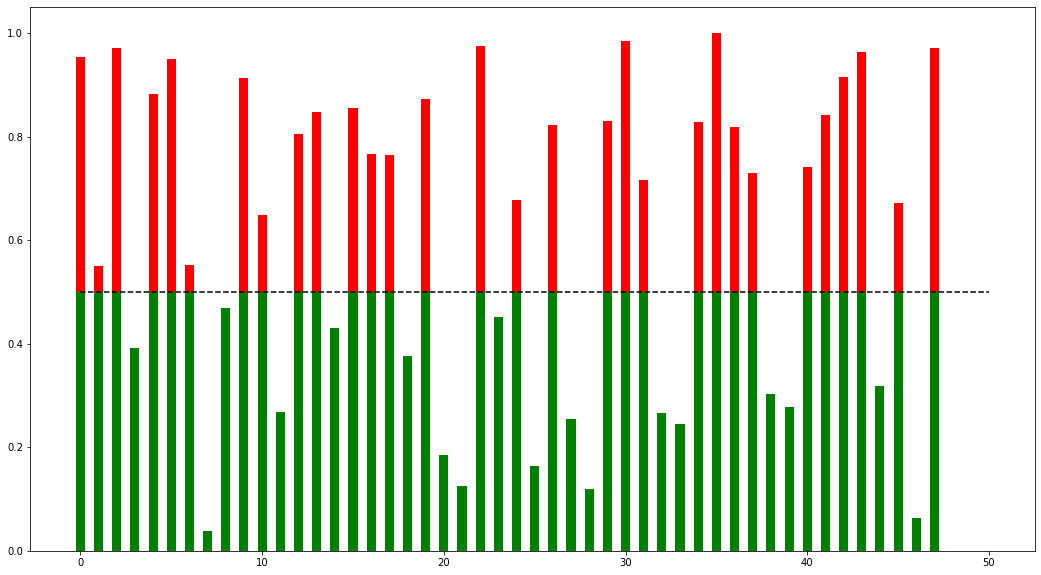

In [43]:
# some example data
threshold = 0.5
values = np.array(list(spam_percentages_0.values()))
x = range(len(values))

# split it up
above_threshold = np.maximum(values - threshold, 0)
below_threshold = np.minimum(values, threshold)

# and plot it
fig, ax = plt.subplots(figsize=(18,10))
ax.bar(x, below_threshold, 0.5, color="g")
ax.bar(x, above_threshold, 0.5, color="r",
        bottom=below_threshold)

# horizontal line indicating the threshold
ax.plot([0., 50], [threshold, threshold], "k--")

As we can see, most topics do a decent job of capturing the spam emails. For example, topic 35 is comprised entirely spam emails and topic 47 is ~97% spam. There are a few topics that are in the 70% region such as topics 31 an 37 and a few at the 60% region such as topics 10 and 24 (64% and 67% respectively). The bigger worry comes with topics such as topic 1 and 6, each of which has 55% spam emails. Referring back to our check of spam% previously our dataset contained roughly 60-62% spam and so the fact that these topics contain less than that may be a cause for questioning. As a result, this threshold can be experimented with to see what model ultimately gives the best fit and we take a look at this later on.

*As an aside, something that would have been interesting to explore further in this project would have been to explore different loss functions for optimising our models. Currently we are optimising the accuracy (the noun, not the measure!) of the model to some extent in predicting the email type. It may be, however, that getting a false negative (letting a spam email through) is much less important to us than a false positive (flagging a ham email as spam). One can see how if a spam email creeps across, ignoring it or deleting is less of a bother than having an important email not come across because it has been labelled as spam. As a result, there may have been different loss functions to explore that give differently weighted penalties based on whether we predict a false negative or a false positive. However, due to time and the fact that this lies outside of the scope of this project, we do not pay attention to this but think it is worth mentioning.*

In [304]:
#we take a look at spam% in the topics we previewed earlier
spam_percentages_0[7], spam_percentages_0[42]

(0.038461538461538464, 0.9155206286836935)

***Remark:*** Looking at this list of spam topics, we note that topic 7 (which we saw before as our 'investment/trading' topic) is not included in spam_topics_0 and is actually the topic with the lowest amount of spam seen in the bar chart above (only 3.8%).<br>
Meanwhile, topic 42 which seemed to be a spammy topic is in spam_topics_0 with approximately 91% of the emails within that topic being spam. This is pretty reassuring as far as our model goes.

We now create a function that uses the steps mentioned above and labels an email as spam if its in a spam topic and ham otherwise. 

In [45]:
def predictSpam(input_df, model=lda_model_0, dictionary=dictionary_0, spam_topics=spam_topics_0):
    #create vector of zeros
    y_pred = [0] * len(input_df)
    #vector with 1 for spam 0 for ham
    y_actual = list(input_df.spam.apply(int))

    for i in range(len(input_df)):
        doc = input_df.iloc[i]
        lem = doc.lemmatized
        
        #find probability distribution of document
        prob_dist = model[dictionary.doc2bow(lem)]
        topic = max(prob_dist, key=lambda item:item[1])[0]
        prob = max(prob_dist, key=lambda item:item[1])[1]
        
        #this section with print()'s is for illustrative purposes for now
        #we find the sum of the 'probabilities' of the document being in a spam topic
        spam_probs = [p for (s,p) in [(a,b) for (a,b) in prob_dist if a in spam_topics]]
        total_spam_prob = sum(spam_probs)
        
        if (total_spam_prob < 0.5) and (topic in spam_topics):
            print(i)
            print('Topic assigned:',topic)
            print('Topic probability:',prob)
            print('Total spam probability:',total_spam_prob)
            print()

        if topic in spam_topics:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
            
    return y_pred, y_actual

In [46]:
y_pred, y_actual = predictSpam(val_df_0, lda_model_0, dictionary_0, spam_topics_0)

20
Topic assigned: 41
Topic probability: 0.45962366
Total spam probability: 0.4884254753123969

272
Topic assigned: 5
Topic probability: 0.2853299
Total spam probability: 0.30083196435589343

370
Topic assigned: 6
Topic probability: 0.47305712
Total spam probability: 0.4908519586897455

521
Topic assigned: 42
Topic probability: 0.39049438
Total spam probability: 0.4223240464925766

528
Topic assigned: 10
Topic probability: 0.4376914
Total spam probability: 0.44249080678855535

641
Topic assigned: 42
Topic probability: 0.39575186
Total spam probability: 0.40180138489813544

758
Topic assigned: 15
Topic probability: 0.37010437
Total spam probability: 0.3789967129123397

759
Topic assigned: 17
Topic probability: 0.2708583
Total spam probability: 0.2852604895597324

785
Topic assigned: 24
Topic probability: 0.45964155
Total spam probability: 0.4666733057674719

950
Topic assigned: 13
Topic probability: 0.40287566
Total spam probability: 0.4095185705082258

1044
Topic assigned: 24
Topic pro

The reason we printed a bunch of email/document numbers and their probabilities above is to illustrate a point that needs to be addressed before going forward. As we are aiming to explore how well the LDA model does as a classifier (and a feature generator later), an easily comparable metric is needed. We decided early on that we would use ROC/AUC for this and so we need to think of how to to assign these values for our topic model. 

We look at the following example to illustrate an important point for the possible approaches:

In [47]:
example_spam_prob = lda_model_0[dictionary_0.doc2bow(val_df_0.iloc[758].lemmatized)]
example_spam_prob

[(0, 0.00030663182),
 (1, 0.00030663182),
 (2, 0.00030663182),
 (3, 0.00030663182),
 (4, 0.00030663182),
 (5, 0.00030663182),
 (6, 0.00030663182),
 (7, 0.00030663182),
 (8, 0.00030663182),
 (9, 0.00030663182),
 (10, 0.00030663182),
 (11, 0.00030663182),
 (12, 0.00030663182),
 (13, 0.00030663182),
 (14, 0.00030663182),
 (15, 0.3678484),
 (16, 0.00030663182),
 (17, 0.00030663182),
 (18, 0.00030663182),
 (19, 0.00030663182),
 (20, 0.00030663182),
 (21, 0.108325236),
 (22, 0.00030663182),
 (23, 0.00030663182),
 (24, 0.00030663182),
 (25, 0.00030663182),
 (26, 0.00030663182),
 (27, 0.00030663182),
 (28, 0.29311767),
 (29, 0.00030663182),
 (30, 0.00030663182),
 (31, 0.00030663182),
 (32, 0.00030663182),
 (33, 0.00030663182),
 (34, 0.00030663182),
 (35, 0.00030663182),
 (36, 0.00030663182),
 (37, 0.00030663182),
 (38, 0.00030663182),
 (39, 0.00030663182),
 (40, 0.00030663182),
 (41, 0.00030663182),
 (42, 0.00030663182),
 (43, 0.00030663182),
 (44, 0.00030663182),
 (45, 0.00030663182),
 (46, 0

In [48]:
#see topic placed in and prob
max(example_spam_prob, key=lambda item:item[1])

(15, 0.3678484)

In [49]:
#check if spam topic
15 in spam_topics_0

True

In [307]:
#check if email itself is spam
val_df_0.iloc[758].spam

False

In [50]:
#check sum of probabilities for all spam topics
sum([p for (s,p) in [(a,b) for (a,b) in example_spam_prob if a in spam_topics_0]])

0.3767407189880032

We consider 2 approaches to how to assign spam probabilities or scores for our documents:

**Approach 1:**
 - Look at the probability of the document being in its assigned document. As per the example above, document 758 in val_df_0 is assigned to topic 15 with probability ~0.37 (this may change slightly with each run). 
 - Check if that topic is spam or not (in this case it is).
     - If spam, then this is the probability we use for ROC.
     - If not spam, then we use `1 - probability` for ROC (vaguely, if we think with prob. 0.7 that something is ham, we think with prob. 0.3 that it's spam)
 - This actually addresses what topic we assign the model to. 
 - Cons:
     - As seen in the example above, we assigned document 758 to be put in topic 15 which is a spam topic. Therefore, for all intents and purposes we would label this document as spam if we were purely using a spam-topic centred approach, even though the email is not actually spam.
     - If the topic is actually ham e.g. if 21 was a ham topic, then we would be saying that the document is not spam with probability ~0.34 and therefore it must be spam with probability 0.66 which contradicts the fact that we have placed the document in a ham topic.

**Aproach 2:**
 - Look at the probability distribution of the document with respect to the different topics.
 - Sum all the probabilities that correspond to a spam topic. In the above example, this would give us ~0.38.
 - Use this probability for the ROC curve.
 - Cons:
     - If the document is placed in a ham topic with prob < 0.5 but the sum of all the spam topic probabilities > 0.5 then we are implying that our model has done a somewhat decent job of identifying the document as spam, even though we have put it in a ham topic and thus labelled it as ham.
     - In the example above, we actually put this email in a spam topic even though we are saying that it is less spammy (and indeed, it's not spam). This may make us question whether we are actually using the actual LDA model as a spam topic classifier or as a feature generator to some extent.

Approach 2 would seemingly work best as it takes into account more information than the probability of being in a single topic and so we decide to go ahead with this approach. However, this is something worth considering and exploring further and it is a bit trickier here as we are essentially using our LDA model as a multiclass classifier (where the number of classes is equal to the number of topics) but then converting its results to a binary classifier (spam vs ham). Given more time, I would have liked to explore how our classifier would perform if we purely decided spam/not spam by the topic it was placed in rather than the sum of probabilities of all spam topics. But we do not do that this time.

In [59]:
def predictSpam(input_df, model=lda_model_0, dictionary=dictionary_0, spam_topics=spam_topics_0):
    #create vector of zeros
    y_pred = [0] * len(input_df)
    #vector with 1 for spam 0 for ham
    y_actual = list(input_df.spam.apply(int))
    #create roc_prob vector
    roc_probs = [0]*len(input_df)

    for i in range(len(input_df)):
        doc = input_df.iloc[i]
        lem = doc.lemmatized
    
        
        #find probability distribution of document
        prob_dist = model[dictionary.doc2bow(lem)]
        topic = max(prob_dist, key=lambda item:item[1])[0]
        prob = max(prob_dist, key=lambda item:item[1])[1]
        
        #sum of spam probabilities
        spam_probs = [p for (s,p) in [(a,b) for (a,b) in prob_dist if a in spam_topics]]
        roc_prob = sum(spam_probs)
        
        #create roc_prob column for df
        roc_probs[i] = roc_prob

        if topic in spam_topics:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
            
    return y_pred, y_actual, roc_probs

In [60]:
y_pred_0, y_actual_0, roc_probs_0 = predictSpam(val_df_0)

In [195]:
def plotROC(input_df,roc_probs,title='Title'):
    fpr, tpr, thresholds = roc_curve(input_df.spam, roc_probs)
    
    plt.subplots(1, figsize=(12,7))

    plt.title(title)
    plt.plot(fpr, tpr)
    
    #plot y=x line for comparison
    plt.plot([0, 1], ls="--")
    #create right-angle shape indiciative of a perfect model
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
    prob = roc_auc_score(input_df.spam, roc_probs)
    print('      ROC AUC Score: {:.4f}'.format(prob))

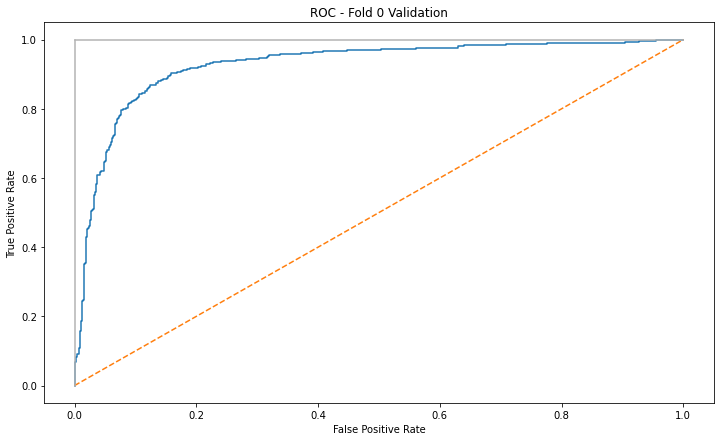

      ROC AUC Score: 0.9262


In [196]:
plotROC(val_df_0,roc_probs_0,title='ROC - Fold 0 Validation')

The model does much better than I had expected it to if we are judging purely on AUC score.<br>
We take a look at a confusion matrix and classification report (we copy this code from the previous group's Assignment 3) for more analysis.

In [56]:
def classificationEval(y_actual,y_pred):
    
    C = confusion_matrix(y_actual,y_pred)
    
    print("Confusion Matrix")
    print(C)
    
    print()
    
    print('Classification report')
    print(classification_report(y_actual, y_pred, target_names = ['Normal', 'Spam'], digits=3))

In [62]:
classificationEval(y_actual_0, y_pred_0)

Confusion Matrix
[[ 589  159]
 [ 116 1130]]

Classification report
              precision    recall  f1-score   support

      Normal      0.835     0.787     0.811       748
        Spam      0.877     0.907     0.892      1246

    accuracy                          0.862      1994
   macro avg      0.856     0.847     0.851      1994
weighted avg      0.861     0.862     0.861      1994



This is an interesting matrix to consider given what we mentioned earlier about different loss functions for false positives and false negatives based on what we are prioritising. As you can see, we have a strong true positive rate shown by spam recall (0.907) but a less great false positive rate (0.213) shown by `159/(589+159)` or `1-Normall recall`.

Realistically, classifying 21% of non-spam emails as spam for an actual spam classifier is probably not a good thing to do. It seems that because our dataset has more spam (due to the way we filtered out replied/forwarded emails as they are unlikely to be spam and are just repeats of existing emails essentially) our classifier is predicting spam much more often relatively speaking. It would be interesting to see how this would perform if a smaller percentage of emails was spam and conversely if almost all the emails were spam.

However, as we have already decided on a metric with no higher-weighted penalties for assigning ham topics to spam for our intents and purposes, our model is doing well.

We now repeat for the test set, though we expect a similar result as we were not optimising over the validation set above. It would, however, not be surprising if we do worse on the test set as there is more unseen data within it that our model may not fit so well compared to the smaller validation set.

In [63]:
y_pred_test_0, y_actual_test_0, roc_prob_test_0 = predictSpam(test_df)

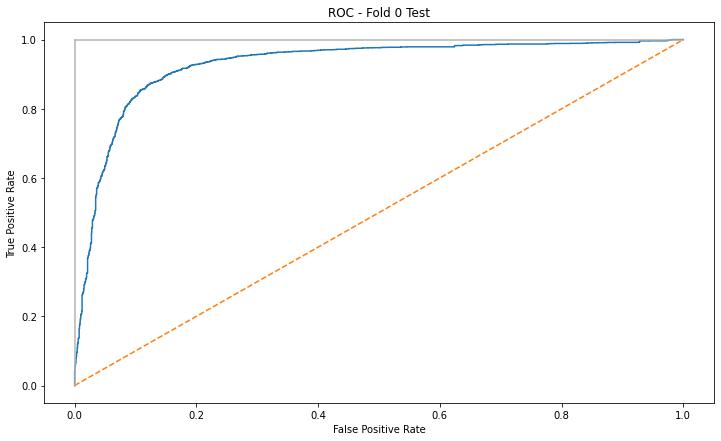

      ROC AUC Score: 0.9280


In [174]:
plotROC(test_df,roc_prob_test_0,title = 'ROC - Fold 0 Test')

In [66]:
classificationEval(y_actual_test_0,y_pred_test_0)

Confusion Matrix
[[1494  387]
 [ 285 2822]]

Classification report
              precision    recall  f1-score   support

      Normal      0.840     0.794     0.816      1881
        Spam      0.879     0.908     0.894      3107

    accuracy                          0.865      4988
   macro avg      0.860     0.851     0.855      4988
weighted avg      0.864     0.865     0.864      4988



The results feel largely similar, both for our classification report/confusion matrix and our ROC/AUC. As mentioned above, this was somewhat expected.

We turn what we did above into functions for easier usage later.

In [67]:
def hamSpam(input_df,dictionary,lda_model,topics=48):
    #loop throuh documents
    topic_spam = {topic:0 for topic in list(range(0,topics))}
    topic_ham = {topic:0 for topic in list(range(0,topics))}
    
    for i in range(0,len(input_df)):

        doc = input_df.iloc[i]
        spam = int(doc.spam)    #gives us 1 if spam, 0 otherwise
        lem = doc.lemmatized

        prob_dist = lda_model[dictionary.doc2bow(lem)]    #prob distribution of document
        topic = max(prob_dist, key=lambda item:item[1])[0]    #topic of document

        if spam:
            topic_spam[topic] += 1
        else:
            topic_ham[topic] += 1

    return topic_spam, topic_ham

In [68]:
def spamPercent(topic_spam_i, topic_ham_i,topics=48):
    spam_percentages = {topic:0 for topic in list(range(0,topics))}

    for topic in topic_spam_i:
        total_ham = topic_ham_i[topic]
        total_spam = topic_spam_i[topic]
        
        spam_percentages[topic] = total_spam/(total_spam + total_ham)
    
    return spam_percentages

In [69]:
def spamTopics(spam_percentages_i,threshold=0.5):
    spam_topics = []

    for topic in spam_percentages_i:
        if spam_percentages_i[topic] > threshold:
            spam_topics.append(topic)
            
    return spam_topics

In [70]:
def predictROC(input_df, model=lda_model_0, dictionary=dictionary_0, spam_topics=spam_topics_0):
    #create roc_prob vector
    roc_probs = [0]*len(input_df)

    for i in range(len(input_df)):
        doc = input_df.iloc[i]
        lem = doc.lemmatized
    
        #find probability distribution of document
        prob_dist = model[dictionary.doc2bow(lem)]
        topic = max(prob_dist, key=lambda item:item[1])[0]
        prob = max(prob_dist, key=lambda item:item[1])[1]
        
        #sum of spam probabilities
        spam_probs = [p for (s,p) in [(a,b) for (a,b) in prob_dist if a in spam_topics]]
        roc_prob = sum(spam_probs)
        
        #create roc_prob column for df
        roc_probs[i] = roc_prob

    return roc_probs

### Checking Other Folds

We now repeat this process for the other folds, as we do not know whether our current fold somehow contains more information of the test set through randomness.

Since we have already done this for fold-0, we need only repeat for folds 1-9.

In [71]:
#create lda model
for i in range(1,10):
    corpus = locals()['bow_corpus_{}'.format(i)]
    dictionary = locals()['dictionary_{}'.format(i)]
    
    locals()['lda_model_{}'.format(i)] = gensim.models.LdaMulticore(corpus, num_topics=48, id2word=dictionary,minimum_probability=0.0,
                                                                    passes=2, workers=cpu_cores,random_state=42,iterations=100)

In [72]:
#create spam/ham counts
for i in range(1,10):
    #fetch train_df_i, lda_model_i, dictionary_i
    train_df_i = locals()['train_df_{}'.format(i)]
    lda_model_i = locals()['lda_model_{}'.format(i)]
    dictionary_i = locals()['dictionary_{}'.format(i)]
    
    topic_spam, topic_ham = hamSpam(train_df_i, dictionary_i, lda_model_i)
    
    locals()['topic_spam_{}'.format(i)] = topic_spam
    locals()['topic_ham_{}'.format(i)] = topic_ham

In [73]:
#find topic spam%
for i in range(1,10):
    topic_ham_i = locals()['topic_ham_{}'.format(i)]
    topic_spam_i = locals()['topic_spam_{}'.format(i)]

    locals()['spam_percentages_{}'.format(i)] = spamPercent(topic_spam_i,topic_ham_i)

In [74]:
#find spam topics
for i in range(1,10):

    spam_percentages_i = locals()['spam_percentages_{}'.format(i)]
            
    locals()['spam_topics_{}'.format(i)] = spamTopics(spam_percentages_i)

In [75]:
#grab probabilities for roc
for i in range(1,10):
    val_df_i = locals()['val_df_{}'.format(i)]
    lda_model_i = locals()['lda_model_{}'.format(i)]
    dictionary_i = locals()['dictionary_{}'.format(i)]
    spam_topics_i = locals()['spam_topics_{}'.format(i)]
    
    roc_probs = predictROC(test_df, lda_model_i, dictionary_i, spam_topics_i)
    
    locals()['roc_probs_{}'.format(i)] = roc_probs

In [76]:
#create vector of auc scores for each fold
fold_scores = [0]*10
fold_scores[0] = roc_auc_score(test_df.spam,roc_prob_test_0)

for i in range(1,10):
    print('Running Fold {} scores'.format(i))
    print()
#     y_actual = locals()['y_actual_{}'.format(i)]
#     y_pred = locals()['y_pred_{}'.format(i)]
    roc_probs = locals()['roc_probs_{}'.format(i)]
    score = roc_auc_score(test_df.spam, roc_probs)
    
    fold_scores[i] = score
    
    print('ROC AUC Score {:.4f}'.format(score))
    print('-'*30)

Running Fold 1 scores

ROC AUC Score 0.8928
------------------------------
Running Fold 2 scores

ROC AUC Score 0.9141
------------------------------
Running Fold 3 scores

ROC AUC Score 0.9072
------------------------------
Running Fold 4 scores

ROC AUC Score 0.9051
------------------------------
Running Fold 5 scores

ROC AUC Score 0.8843
------------------------------
Running Fold 6 scores

ROC AUC Score 0.9065
------------------------------
Running Fold 7 scores

ROC AUC Score 0.8982
------------------------------
Running Fold 8 scores

ROC AUC Score 0.9297
------------------------------
Running Fold 9 scores

ROC AUC Score 0.9405
------------------------------


In [77]:
fold_scores

[0.9279903707342598,
 0.8928457580736813,
 0.9140508980852518,
 0.9072437997784837,
 0.9051319010579086,
 0.8843312600194344,
 0.9065094904117146,
 0.8981617369637629,
 0.9296626933711276,
 0.9404749132782607]

In [78]:
#average
sum(fold_scores)/10

0.9106402821773886

It seems that we score similarly for ROC/AUC across all our folds and so we can conclude that we are not gaining improved performance through some randomness within our training set.

# Tuning Parameters

We now want to run cross-validation on different numbers of topics to see what the best topic number is for our classifier. We expect this to be in the higher end of whatever range we expect it to be different than the previous group's Assignment 3 as they were optimising for coherence/perplexity and not performance.

We tried optimising for a wide range of topics (2-79) and assigning multiple thresholds for what we consider a spam topic (5 evenly spaced increments between 0.5 as a natural cut-off up to 0.62 which is roughly amount of spam in our dataset) but this took too long to run and we concluded that it was not necessarily for this assignment. The code is left below but commented out.

In [80]:
# score_df = pd.DataFrame(columns=['k','t','score'])

# for k in range(2,80):
    
#     for t in np.linspace(0.5,0.62,5):
#         fold_scores = [0]*10
    
#         for i in range(0,10):
#             corpus = locals()['bow_corpus_{}'.format(i)]
#             dictionary = locals()['dictionary_{}'.format(i)]
#             train_df_i = locals()['train_df_{}'.format(i)]
#             val_df_i = locals()['val_df_{}'.format(i)]
            
#             start = time.time()

#             lda_model_i_k = gensim.models.LdaMulticore(corpus, num_topics=k, id2word=dictionary,minimum_probability=0.0,
#                                                        passes=2, workers=cpu_cores,random_state=42)
            
#             lda_time = time.time() - start
#             print('LDA Model Fold {} with {} topics initialised after {:.2f} seconds'.format(i+1,k,lda_time))
            

#             topic_spam, topic_ham = hamSpam(train_df_i, dictionary, lda_model_i_k,k)
#             spam_percentages = spamPercent(topic_spam,topic_ham)
            
#             spam_time = time.time() - start
#             print('Spam calculated after {:.2f} seconds'.format(spam_time))

#             spam_topics = spamTopics(spam_percentages, threshold = t)
#             roc_probs = predictROC(val_df_i, lda_model_i_k, dictionary, spam_topics)
            
#             roc_time = time.time() - start
#             print('ROC calculated after {:.2f} seconds'.format(roc_time))
            
#             score = roc_auc_score(val_df_i.spam,roc_probs)
#             fold_scores[i] = score
#             print('-'*10)
            
#         average_score = sum(fold_scores)/10
#         score_df.append({'k':k,'t':t,'score':average_score},ignore_index=True)
        
#         print('Average AUC score for LDA model with {k} topics, with a spam threshold of {t}: {:.4f}'.format(k,t,average_score))
#         print('-'*50)

LDA Model Fold 1 with 2 topics initialised after 17.58 seconds<br>
Spam calculated after 34.35 seconds<br>
ROC calculated after 36.48 seconds<br>
\----------<br>
LDA Model Fold 2 with 2 topics initialised after 20.45 seconds<br>
Spam calculated after 37.85 seconds<br>
ROC calculated after 39.45 seconds<br>
\----------<br>
LDA Model Fold 3 with 2 topics initialised after 18.72 seconds<br>
Spam calculated after 35.83 seconds<br>
ROC calculated after 37.77 seconds<br>
\----------<br>
LDA Model Fold 4 with 2 topics initialised after 25.02 seconds<br>
Spam calculated after 44.55 seconds<br>
ROC calculated after 46.59 seconds<br>
...


At 40 seconds per fold, for 10 folds, 5 thresholds, and 79 topics, the code above would seemingly take about 43 hours to run. 

Instead we run our model for one fold (train_df_8 in this case) and reduce number of topics to 50 and number of thresholds to 1. This should take ~30 minutes to run instead which may not be incredibly fast but it is better than the process above. However, we also add functions to calculate coherence and perplexity to present us with some more analysis, though since we are focused on classification performance, we will still use AUC as the decider for number of topics. This increases our total runtime to ~60 minutes.

The reason we reduce the number of thresholds down to just one (t=0.5) is because in retrospect, the average number of spam emails should not be known to us and we are likely to see better performance when t=0.62$\approx$total_spam_%. It may however also be the case that the 'natural' threshold of 50% would perform worse under a different dataset where spam is much less prevalent than in our set. An ideal approach would be to optimising over thresholds in a wide range, say, between 0.2 and 0.7 with small increments to encompass a wider variety of datasets. For our purposes, we leave this threshold to 0.5.


In [110]:
score_df = pd.DataFrame(columns=['topics','score','coherence','log_perplexity'])
beginning = time.time()

for k in range(2,50):
    start_k = time.time()
    #check threshold for 5 even increments between 0.5  and 0.62
    
    corpus = bow_corpus_8
    dictionary = dictionary_8
    train_df_i = train_df_8
    val_df_i = val_df_8
    
    lda_model_i = gensim.models.LdaMulticore(corpus, num_topics=k, id2word=dictionary,minimum_probability=0.0,
                                             passes=2, workers=cpu_cores,random_state=42)
    
    lda_time = time.time() - start_k
    print('LDA Model with {} topics initialised after {:.2f} seconds'.format(k,lda_time))
    
    cm = gensim.models.coherencemodel.CoherenceModel(model=lda_model_i, corpus=corpus,
                                                     dictionary=dictionary, coherence='u_mass') 
    coh = cm.get_coherence()
    
    coh_time = time.time() - start_k
    print('Coherence calculated after {:.2f} seconds'.format(coh_time))
    
    log_perplexity = lda_model_i.log_perplexity(corpus)
    perp_time = time.time() - start_k
    print('Log-perplexity calculated after {:.2f} seconds'.format(perp_time))

    topic_spam, topic_ham = hamSpam(train_df_i, dictionary, lda_model_i,k)
    spam_percentages = spamPercent(topic_spam,topic_ham)
    spam_topics = spamTopics(spam_percentages)
    spam_time = time.time() - start_k
    print('Spam calculated after {:.2f} seconds'.format(spam_time))

    roc_probs = predictROC(val_df_i, lda_model_i, dictionary, spam_topics)
    roc_time = time.time() - start_k
    print('ROC calculated after {:.2f} seconds'.format(roc_time))

    score = roc_auc_score(val_df_i.spam,roc_probs)
    
    
    score_df = score_df.append({'topics':k,
                                'score':score,
                                'coherence':coh,
                                'log_perplexity':log_perplexity},ignore_index=True)
    inter_time = time.time() - beginning

    print('AUC score for LDA model with {} topics: {:.4f}'.format(k,score))
    print('Total time elapsed: {:.2f}'.format(inter_time))
    print('-'*50)
    

end = time.time()
print('Total time: {:.2f}'.format(end-beginning))

LDA Model with 2 topics initialised after 23.42 seconds
Coherence calculated after 23.71 seconds
Log-perplexity calculated after 39.13 seconds
Spam calculated after 55.51 seconds
ROC calculated after 57.28 seconds
AUC score for LDA model with 2 topics: 0.6796
Total time elapsed: 57.29
--------------------------------------------------
LDA Model with 3 topics initialised after 20.38 seconds
Coherence calculated after 20.70 seconds
Log-perplexity calculated after 36.52 seconds
Spam calculated after 53.19 seconds
ROC calculated after 55.04 seconds
AUC score for LDA model with 3 topics: 0.7079
Total time elapsed: 112.33
--------------------------------------------------
LDA Model with 4 topics initialised after 20.23 seconds
Coherence calculated after 20.60 seconds
Log-perplexity calculated after 35.97 seconds
Spam calculated after 52.59 seconds
ROC calculated after 54.46 seconds
AUC score for LDA model with 4 topics: 0.7731
Total time elapsed: 166.79
--------------------------------------

Coherence calculated after 22.10 seconds
Log-perplexity calculated after 38.56 seconds
Spam calculated after 57.03 seconds
ROC calculated after 59.04 seconds
AUC score for LDA model with 26 topics: 0.8790
Total time elapsed: 1409.93
--------------------------------------------------
LDA Model with 27 topics initialised after 22.17 seconds
Coherence calculated after 22.99 seconds
Log-perplexity calculated after 39.84 seconds
Spam calculated after 59.06 seconds
ROC calculated after 61.11 seconds
AUC score for LDA model with 27 topics: 0.8928
Total time elapsed: 1471.05
--------------------------------------------------
LDA Model with 28 topics initialised after 21.69 seconds
Coherence calculated after 22.56 seconds
Log-perplexity calculated after 39.30 seconds
Spam calculated after 57.98 seconds
ROC calculated after 60.09 seconds
AUC score for LDA model with 28 topics: 0.9105
Total time elapsed: 1531.15
--------------------------------------------------
LDA Model with 29 topics initialis

In [111]:
#we look at the higher end of our range
score_df.tail(10)

,topics,score,coherence,log_perplexity
38,40.0,0.942545,-1.796173,-7.705301
39,41.0,0.922442,-1.765682,-7.714566
40,42.0,0.929621,-1.719132,-7.722941
41,43.0,0.936979,-1.860995,-7.722565
42,44.0,0.916307,-1.810601,-7.735442
43,45.0,0.927502,-1.749859,-7.741785
44,46.0,0.908513,-1.994636,-7.735265
45,47.0,0.934016,-1.883096,-7.758820
46,48.0,0.925792,-1.944841,-7.751750
47,49.0,0.940009,-2.002712,-7.776435


Text(0, 0.5, 'Log-Perplexity')

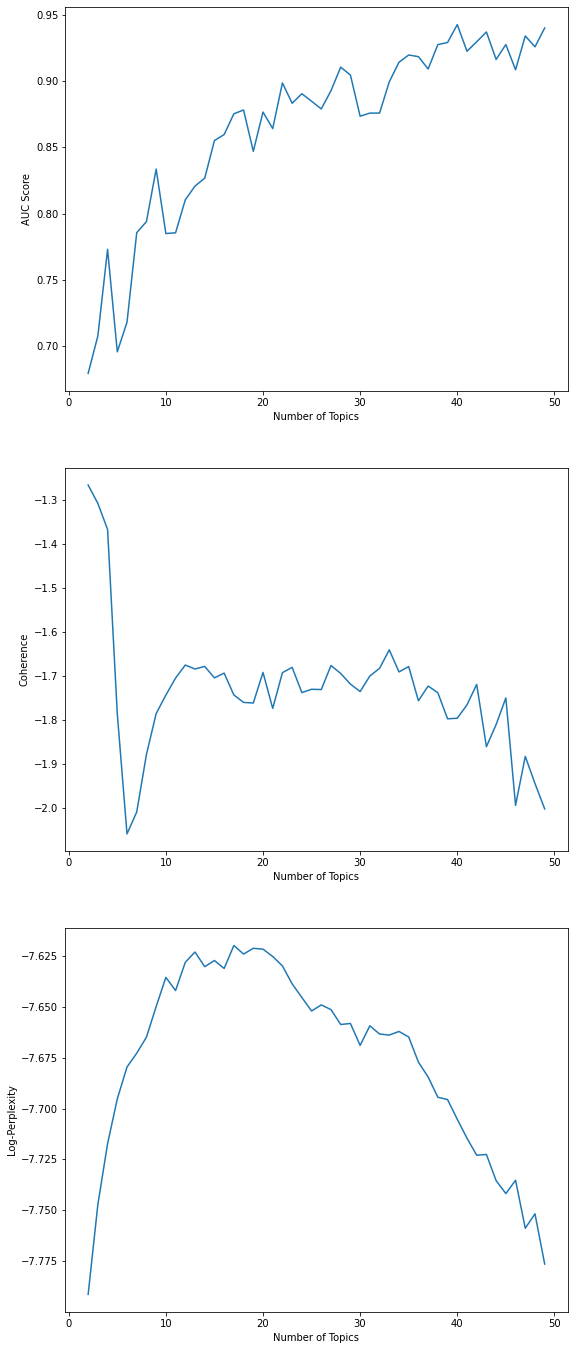

In [113]:
f, (ax1,ax2,ax3) = plt.subplots(nrows=3,ncols=1, figsize=(9,24))

x = score_df['topics']
y1 = score_df['score']
y2 = score_df['coherence']
y3 = score_df['log_perplexity']

#plot auc 
ax1.plot(x,y1)
ax1.set_xlabel('Number of Topics')
ax1.set_ylabel('AUC Score')

#plot coherence
ax2.plot(x,y2)
ax2.set_xlabel('Number of Topics')
ax2.set_ylabel('Coherence')

#plot log-perplexity
ax3.plot(x,y3)
ax3.set_xlabel('Number of Topics')
ax3.set_ylabel('Log-Perplexity')

# plt.title('ROC - Fold 0')
# plt.plot(fpr, tpr)
# plt.plot([0, 1], ls="--")
# plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.show()


We have some interesting results here. Since we used u_mass for our coherence, we do want a lower or 'more negative' to indicate better coherence of terms within a topic. Similarly, we want low perplexity.

As per [this article](https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0) perplexity should illustrate well the model is able to reproduce the statistics out-of-sample data, whereas coherence is meant to be indicative of how similar the words within the topics are; really, how coherent the topic is given the words that are representative of that topic.

Although highest auc score, lowest u_mass, and lowest log_perplexity do not match at the same number of topics, we can see an increase trend in the former and a decreasing trend in the latter two as we increase the number of topics. This could mean that if we were to increase topics further, there would be a point where all these measures agree with one another. Below we look at what 'optimal' topic number is as per the best result for each measure.

In [267]:
max_score = score_df[score_df.score==max(score_df.score)]
min_coh = score_df[score_df.coherence==min(score_df.coherence)]
min_perp = score_df[score_df.log_perplexity==min(score_df.log_perplexity)]

In [116]:
max_score

,topics,score,coherence,log_perplexity
38,40.0,0.942545,-1.796173,-7.705301


In [269]:
min_coh

,topics,score,coherence,log_perplexity
4,6.0,0.718237,-2.059627,-7.679603


In [119]:
min_perp

,topics,score,coherence,log_perplexity
0,2.0,0.67962,-1.265,-7.791311


As mentioned above, these measures do not agree with one another for our model. It is worth noting, however, that better coherence does not actually mean that our topics make more sense; the same goes for lower perplexity. That is to say the measures are not really reflective of human understanding or interpretation of topics, though that does not mean that we should ignore them, only that we should be wary that increasing number of topics continuously may yield seemingly better results but reduce actual interpretability of our topics.

Having said this, looking at the previous Assignment 3 (linked in references), their coherence scores seem to be more consistent (though they used c_v rather than u_mass) as do their log_perplexities (we used the same measure here) than ours. The reason for this may be how we processed our data compared to them. Given time, this may have been something worth exploring further by implementing bigrams/trigrams, removing some shorter words, and/or numbers from our email dataset. 

However, as our focus for this project is to assess how well an LDA model can be used to classify spam/ham and how effective it can be for generating features for other classifiers to predict spam/ham, interpretability is not our main concern. Though having consistent/interpretable data would have been nice.

We assign our optimal number of topics to be the one that gives us the highest AUC score as this is more aligned with our project aim.

In [120]:
topic_max = int(max_score['topics'])
topic_max

40

So now that we have tuned our parameter for number of topics, we can train on the entire training data rather than excluding the validation set.<br>
For this we will obviously need to create a new dictionary and corpus first.

In [212]:
final_dictionary = gensim.corpora.Dictionary(train_df.lemmatized)
final_dictionary.filter_extremes(no_below=15, no_above=0.5)

final_bow_corpus = [final_dictionary.doc2bow(doc) for doc in train_df.lemmatized]

In [215]:
corpus = final_bow_corpus
dictionary = final_dictionary
# corpus = bow_corpus_8
# dictionary = dictionary_8 

final_lda = gensim.models.LdaMulticore(corpus, num_topics=topic_max, id2word=dictionary,minimum_probability=0.0,
                                       passes=2, workers=cpu_cores,random_state=42)

#we now train on whole train_df instead of train_df_8
final_topic_spam, final_topic_ham = hamSpam(train_df, dictionary, final_lda, topics=topic_max)
final_spam_percentages = spamPercent(final_topic_spam,final_topic_ham)
final_spam_topics = spamTopics(final_spam_percentages)
#run on test_df
y_final_pred, y_final_actual, final_roc_probs = predictSpam(test_df, final_lda, dictionary, final_spam_topics)

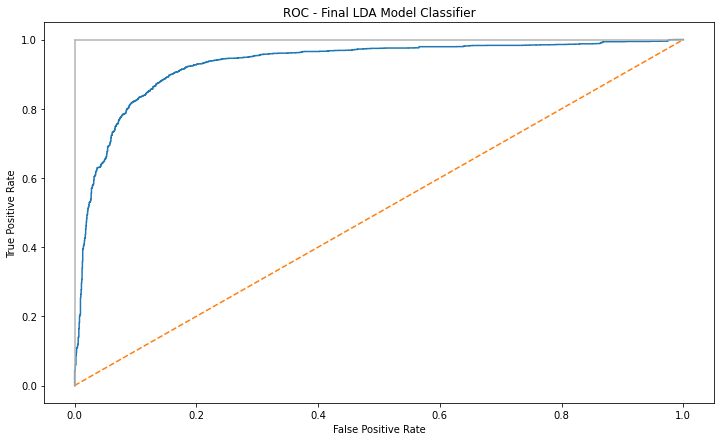

      ROC AUC Score: 0.9297


In [216]:
plotROC(test_df,final_roc_probs,title = 'ROC - Final LDA Model Classifier')

We see an ROC/AUC very similar to what we got with our validation sets earlier which is a good sign. Notably this score of ~0.93 is quite close to our core of ~0.94 which we got as max AUC when optimising number of topics. Typically it would not be unexpected for the prediction on the test set to perform worse. This casts away doubts that we might be overfitting somehow as we kept increasing the number of topics.

In [217]:
lda_roc_plot = roc_curve(test_df.spam, final_roc_probs)

In [218]:
np.save('..\data\LDA_Model_Classifier_ROC',lda_roc_plot)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
C:\Users\Mohammed\AppData\Local\Temp/ipykernel_6236/1999903019.py:1: DeprecationWarning: invalid escape sequence \d
  np.save('..\data\LDA_Model_Classifier_ROC',lda_roc_plot)


In [221]:
classificationEval(y_final_actual,y_final_pred)

Confusion Matrix
[[1526  355]
 [ 323 2784]]

Classification report
              precision    recall  f1-score   support

      Normal      0.825     0.811     0.818      1881
        Spam      0.887     0.896     0.891      3107

    accuracy                          0.864      4988
   macro avg      0.856     0.854     0.855      4988
weighted avg      0.864     0.864     0.864      4988



It is worth nothing however, that we are seemingly doing better at not classifying ham emails as spam (19% here compared to 21% before) though this may not be very significant.

# SVM Classifier

We now instead create a dictionary of probabilities to use as a set of features for an SVM Classifier and see if that improves our results (we expect that it will as this should contain more information than single probabilities for spam/ham).

In [236]:
#create empty df with column for each topic
prob_df = pd.DataFrame(columns = list(range(0,topic_max)))

#training set probability distributions
for i in range(0,len(train_df)):
    doc = train_df.iloc[i]
    lem = doc.lemmatized
    
    #grab probability distribution as per final_lda model
    prob_dist = final_lda[dictionary.doc2bow(lem)]
    #dictionary of probabilities
    prob_dic = {a:b for (a,b) in prob_dist}
    
    #add features for document i
    prob_df = prob_df.append(prob_dic,ignore_index=True)

In [237]:
#preview some columns and some rows
prob_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,...,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463,0.000463
1,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.991211,0.000225,0.000225,0.000225,...,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225
2,0.000424,0.000424,0.000424,0.000424,0.000424,0.603423,0.000424,0.000424,0.000424,0.000424,...,0.000424,0.000424,0.000424,0.000424,0.000424,0.000424,0.000424,0.000424,0.000424,0.000424
3,0.000862,0.000862,0.000862,0.000862,0.340367,0.000862,0.000862,0.000862,0.000862,0.000862,...,0.000862,0.000862,0.000862,0.000862,0.000862,0.000862,0.350013,0.000862,0.000862,0.000862
4,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.418828,0.000269,0.000269,0.000269,...,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269,0.000269
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19939,0.000223,0.000223,0.074552,0.000223,0.421318,0.000223,0.000223,0.000223,0.000223,0.000223,...,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223,0.000223
19940,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,...,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137,0.001137
19941,0.000225,0.000225,0.000225,0.000225,0.000225,0.117781,0.000225,0.000225,0.000225,0.000225,...,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225,0.000225
19942,0.002273,0.002273,0.002273,0.002273,0.198370,0.002273,0.002273,0.002273,0.002273,0.715253,...,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273,0.002273


In [238]:
#create datafram as above this time for test data
test_prob_df = pd.DataFrame(columns = list(range(0,topic_max)))

#extract features from test data to feed to SVM
for i in range(0,len(test_df)):
    doc = test_df.iloc[i]
    lem = doc.lemmatized
    
    prob_dist = final_lda[dictionary.doc2bow(lem)]
    prob_dic = {a:b for (a,b) in prob_dist}
    
    test_prob_df = test_prob_df.append(prob_dic,ignore_index=True)

In [239]:
test_prob_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.002274,0.002274,0.002274,0.002274,0.002274,0.702470,0.002274,0.002274,0.002274,0.002274,...,0.002274,0.002274,0.002274,0.002274,0.002274,0.002274,0.002274,0.002274,0.002274,0.002274
1,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,...,0.378788,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431,0.000431
2,0.000138,0.000138,0.000138,0.000138,0.722656,0.000138,0.000138,0.000138,0.000138,0.000138,...,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.000138,0.092109
3,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,...,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439,0.000439
4,0.000556,0.000556,0.000556,0.000556,0.096020,0.000556,0.000556,0.000556,0.000556,0.000556,...,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556,0.000556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4983,0.000137,0.000137,0.000137,0.000137,0.000137,0.199708,0.457629,0.000137,0.000137,0.000137,...,0.000137,0.000137,0.000137,0.000137,0.046335,0.000137,0.127040,0.000137,0.000137,0.000137
4984,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,...,0.000150,0.000150,0.994160,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150,0.000150
4985,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.970452,...,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758,0.000758
4986,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.991051,0.000229,0.000229,0.000229,...,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229,0.000229


In [240]:
#our features are probabilities for each topic given by prob_df
X = prob_df
# X_scale = scale(X)  #this raised some warnings about zeros so commented out just in case

#our target vector corresponding to spam True/False
y = train_df.spam

#assign svm model with probabilities instead of binary classes so we can use the results for ROC
clf = svm.SVC(probability=True)
#train model
clf.fit(X,y)

SVC(probability=True)

In [242]:
#features and scaling
X_test = test_prob_df
# X_test = scale(X_test) #commented out for same reason as above

#target
y_test = test_df.spam

#predict probabilites
y_pred = clf.predict_proba(X_test)

In [243]:
#left 'column' corresponds to class 0 i.e. not spam
y_pred

array([[0.90936461, 0.09063539],
       [0.01893797, 0.98106203],
       [0.07122309, 0.92877691],
       ...,
       [0.86930157, 0.13069843],
       [0.87232547, 0.12767453],
       [0.09031689, 0.90968311]])

In [244]:
#grab all spam scores and preview
y_pred = [b for (a,b) in y_pred]
y_pred[:10]

[0.09063539289589757,
 0.9810620311714737,
 0.9287769050879944,
 0.9092259053042959,
 0.337310973243348,
 0.9049796595492894,
 0.9682753508887088,
 0.05181153372584924,
 0.9038719336325619,
 0.9536699303492644]

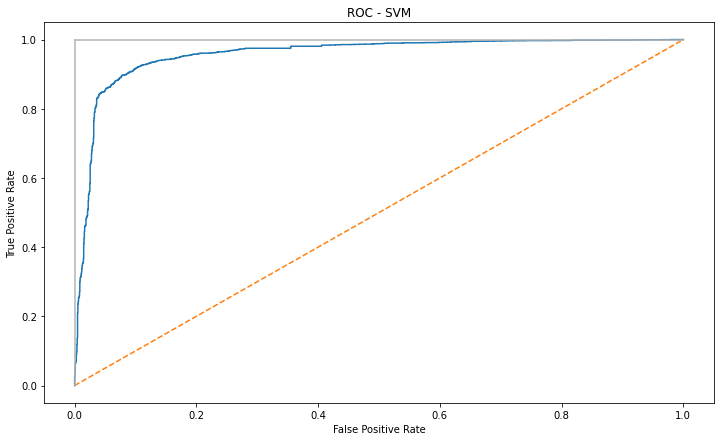

      ROC AUC Score: 0.9575


In [245]:
plotROC(test_df,y_pred,title='ROC - SVM')

This seemingly is an improvement over what we had with the LDA Model Classifier previously which we expected to happen. The degree of improvement is not incredibly large but that is understandable given how well the LDA Model was doing already.

In [246]:
lda_svm_roc_plot = roc_curve(test_df.spam,y_pred)

In [247]:
np.save('..\data\LDA_SVM_ROC',lda_svm_roc_plot)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
C:\Users\Mohammed\AppData\Local\Temp/ipykernel_6236/3728174589.py:1: DeprecationWarning: invalid escape sequence \d
  np.save('..\data\LDA_SVM_ROC',lda_svm_roc_plot)


# Simple Classifier

This is a classifier that Oliver suggested and it's copied from his code. The idea is to take a dot product of individual topic probabilities against the spam vector and then divide by the sum of all the 'probabilities' for that topic. Effectively, we are giving a weight to each topic that by summing all the probabilities of that topic for spam and dividing by the sum of all its probabilities. Doing this for each topic or column, we can then sum each row's topic scores/weights to produce a final spam score.

In [248]:
def upgraded_classifier(prob_df, truth):
    
    numtopics = len(prob_df.iloc[0])
    topicweight = np.zeros(numtopics)
    
    for i in range(numtopics):
        topic = prob_df[i]
        totalprob = sum(topic)
        
        spamprob = np.dot(topic, truth)
        
        if totalprob == 0:
            topicweight[i] = 0
        else:
            topicweight[i] = spamprob / totalprob
    #return is a function
    return (lambda x: np.dot(x, topicweight))

In [249]:
#create a dataframe where we store spam scores
up_class_df = pd.DataFrame(columns = ['spam_score'])
#call the function
uc = upgraded_classifier(test_prob_df,test_df.spam)

for i in range(0,len(test_prob_df)):
    #get score for row i
    spam_score = uc(test_prob_df.iloc[i])
    up_class_df = up_class_df.append({'spam_score':spam_score},ignore_index=True)

In [250]:
up_class_df.head()

,spam_score
0,0.356095
1,0.811157
2,0.863676
3,0.929526
4,0.611171


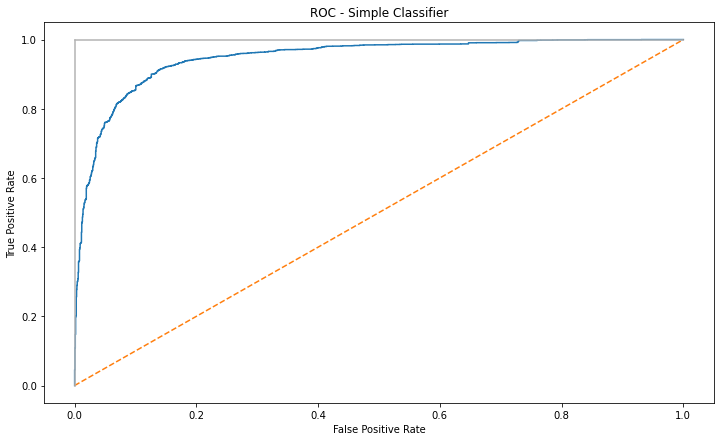

      ROC AUC Score: 0.9476


In [251]:
plotROC(test_df,up_class_df.spam_score,title='ROC - Simple Classifier')

In [253]:
lda_custom_classifier_plot = roc_curve(test_df.spam,up_class_df.spam_score)

In [254]:
np.save('..\data\LDA_Custom_Classifier_ROC',lda_custom_classifier_plot)

<>:1: DeprecationWarning: invalid escape sequence \d
<>:1: DeprecationWarning: invalid escape sequence \d
C:\Users\Mohammed\AppData\Local\Temp/ipykernel_6236/3921667500.py:1: DeprecationWarning: invalid escape sequence \d
  np.save('..\data\LDA_Custom_Classifier_ROC',lda_custom_classifier_plot)


Plotting everything together:

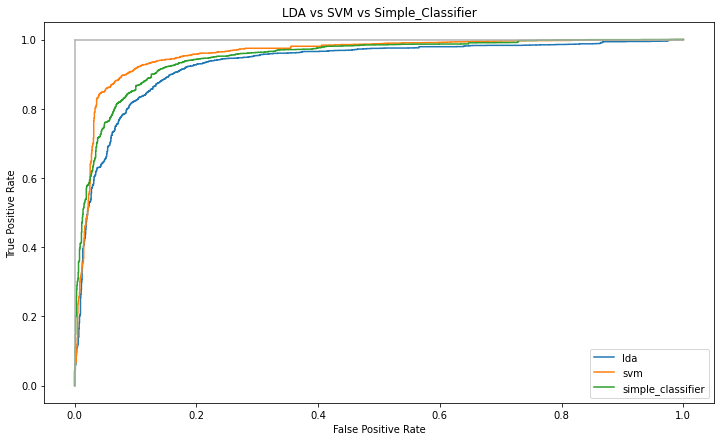

      ROC AUC Score (LDA): 0.9297
      ROC AUC Score (SVM): 0.9575
      ROC AUC Score (Simple Classifier): 0.9476


In [252]:
plt.subplots(1, figsize=(12,7))

fpr1, tpr1, thresholds = roc_curve(test_df.spam, final_roc_probs)
fpr2, tpr2, thresholds = roc_curve(test_df.spam,y_pred)
fpr3, tpr3, thresholds = roc_curve(test_df.spam,up_class_df.spam_score)

plt.title('LDA vs SVM vs Simple_Classifier')
plt.plot(fpr1, tpr1, label='lda')
plt.plot(fpr2, tpr2, label='svm')
plt.plot(fpr3, tpr3, label='simple_classifier')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend()

plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

plt.show()

prob1 = roc_auc_score(test_df.spam, final_roc_probs)
prob2 = roc_auc_score(test_df.spam, y_pred)
prob3 = roc_auc_score(test_df.spam, up_class_df.spam_score)

print('      ROC AUC Score (LDA): {:.4f}'.format(prob1))
print('      ROC AUC Score (SVM): {:.4f}'.format(prob2))
print('      ROC AUC Score (Simple Classifier): {:.4f}'.format(prob3))

Now that we have our ROC curves plotted on the same graph it is easier to directly compare our classifiers. SVM performs best, followed by our simple classifier, and the lda model.

# Conclusion

We aimed to use an LDA model to assign each email within our dataset to a specific topic and from that infer whether the email was spam or not. Unlike the previous group's Assignment 3 that this project was inspired by, we opted to use multiple topics rather than 2 topics that we'd hope to correspond to spam/ham (which is what they did). The intuition behind this was that it's not necessarily the case that all spam emails would be incredibly similar to the point where they can cleanly be split into a separate topic and spam such as 'deals' or 'offers' naturally will share similarities with trade deals or stock offerings (though maybe using bigrams/trigrams would've made such a split cleaner/more accurate). 

Instead, we took their number of topics that corresponded to the highest coherence score for them (48 topics) and labelled each topic as spam or ham topic based on the amount of spam that was put into it. This makes sense since it is natural for there to be differet types of spam topics e.g. holiday deals vs free products vs subscription offers, rather than a singular spam topic. Similarly, it makes sense for there to be multiple ham topics and so in many ways this approach seemed more natural to us. One thing to say about our approach however is that maybe it involves some meta interference as we were counting labels going into our model for our training and honestly I am unsure whether that approach for assigning spam topics was to some extent 'cheating'.

**LDA as a 'classifier':**<br>
This was our worst-performing (but quite good) model. We assigned scores to each email based on the sum of the likelihoods that our LDA model would place the email into a spam topic and then used those scores to plot an ROC curve and assess the performance of our model. The strange part about this was that it was not unlikely for us to assign a low spam score e.g. 0.35 to an email that was actually assigned to a spam topic since almost all its spam score was centred on one topic. This raises the question of how would we actually label something as spam which would likely be through optimising over a threshold for our spam score. We did not do this, however, due to time constraints and because it did not necessarily aid our comparison via our chosen metric of ROC/AUC.

**LDA as a feature generator:**<br>
We created features out of the probability that an email was put into each topic to feed to a different classifier and assess performance. We used this with SVM but we also wanted to compare a simple classifier that assigned spam weights to each topic and then a spam score based on those weights for each email/document. 

The SVM performed better than the other two models, somewhat expectedly as it uses more information than the LDA model and a more rigorous approach than our other simple classifier. Furhter, the SVM classifier can naturally give us predictions our probabilities based on what function we call and so we would not have to mess around with thresholds to see what we should assign as spam/ham based on spam scores, which would be nice were we to need to do that.

Our simple custom classifier did similarly well and was our second best performing model, again because assigning a weight to a topic based on how spammy it is gives us more information than whether that topic has more than a fixed % of spam emails within it.



As a result, we can conclude that our LDA topic model was a good generator of features for classifiers that would not be able to just use the text in a document/email for classification. We did not explore a pure topic classification approach to LDA where our spam/ham scores where our probabilities would correspond purely to what topic an email goes into. This may have been worth exploring given more time, especially since our approach for LDA classification and our simple custom classifier were not so different in essence. Further, we did not explore loss functions or weighted-penalties for assigning ham emails as spam which in a realistic setting would cause us more 'loss' than assigning a spam email as ham. This also would have been interesting to explore given more time, but it would have also been a separate scope in and of itself.


# References

GitHub Assessment 3:https://github.com/xiaozhang-github/DST-Assessment-3/blob/main/Report/03%20-%20Alex%20TF-IDF.ipynb <br>
Plotting ROC Curves: https://www.projectpro.io/recipes/plot-roc-curve-in-python